# Streaming

## Learning goals

* Understand how streaming works
* Work with stream events 

Let's start by importing the `anthropic` SDK and setting up our client:

In [1]:
from dotenv import load_dotenv
from anthropic import Anthropic

#load environment variable
load_dotenv()

#automatically looks for an "ANTHROPIC_API_KEY" environment variable
client = Anthropic()

So far, we've sent messages to Claude using the following syntax: 


In [3]:
response = client.messages.create(
    messages=[
        {
            "role": "user",
            "content": "Write me an essay about macaws and clay licks in the Amazon",
        }
    ],
    model="claude-3-haiku-20240307",
    max_tokens=800,
    temperature=0,
)
print("We have a response back!")
print("========================")
print(response.content[0].text)

We have a response back!
Here is an essay about macaws and clay licks in the Amazon:

Macaws and Clay Licks in the Amazon

Deep within the lush, verdant rainforests of the Amazon basin, a remarkable natural phenomenon takes place. Flashes of vibrant color dart through the canopy, as large, magnificent parrots known as macaws congregate at special sites called clay licks. These clay licks, or "collpas" as they are known locally, are essential to the survival and well-being of macaws and other Amazonian wildlife.

Macaws are some of the most striking and iconic birds of the Amazon. With their vividly-hued plumage, hooked beaks, and long, tapered tails, these large parrots are a sight to behold as they soar through the treetops. The most well-known species include the scarlet macaw, the blue-and-gold macaw, and the green-winged macaw, each adorned in a stunning array of reds, blues, greens, and golds. 

These magnificent birds play a crucial role in the Amazon ecosystem, acting as importa

This works fine, but it's important to remember that with this approach, we only get content back from the API **once all of the content has been generated.** Try running the above cell again, and you'll see that nothing is printed out until the entire response is printed all at once. This is fine in many situations, but it can lead to bad user experiences if you're building an application that forces a user to wait around for an entire response to be generated.

**Enter streaming!**

Streaming enables us to write applications that receive content as it is generated by the model, rather than having to wait for the entire response to be generated. This is how apps like claude.ai work. As the model generates responses, that content is streamed to a user's browser and displayed:

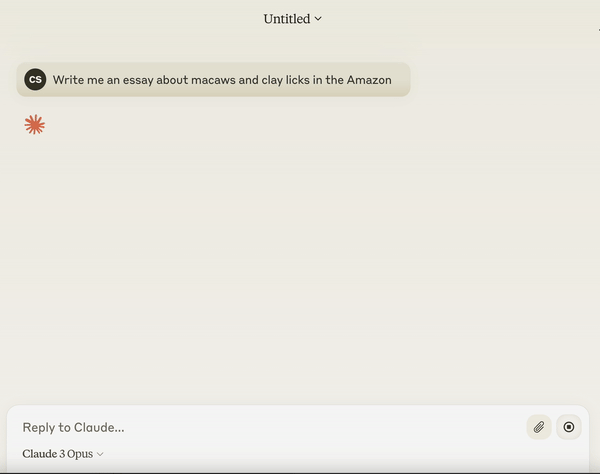

## Working with streams

To get a streaming response from the API, it's as simple as passing `stream=True` to `client.messages.create`.  That's the easy part. Where things get a little trickier is in how we subsequently work with the streaming response and handle incoming data. 

In [4]:
stream = client.messages.create(
    messages=[
        {
            "role": "user",
            "content": "Write me a 3 word sentence, without a preamble.  Just give me 3 words",
        }
    ],
    model="claude-3-haiku-20240307",
    max_tokens=100,
    temperature=0,
    stream=True,
)

Let's take a look at our `stream` variable

In [5]:
stream

There's not much to look at!  This stream object on its own won't do a whole lot for us. The stream object is a generator object that yields individual server-sent events (SSE) as they are received from the API. We need to write code to iterate over it and work with each individual server-sent event.  Remember, our data is no longer coming in one finalized chunk of data.  Let's try iterating over the stream response:

In [6]:
for event in stream:
    print(event)

MessageStartEvent(message=Message(id='msg_01EZHjA6qmf6y8VWMZSeBmN5', content=[], model='claude-3-haiku-20240307', role='assistant', stop_reason=None, stop_sequence=None, type='message', usage=Usage(input_tokens=30, output_tokens=2)), type='message_start')
ContentBlockStartEvent(content_block=ContentBlock(text='', type='text'), index=0, type='content_block_start')
ContentBlockDeltaEvent(delta=TextDelta(text='Cats', type='text_delta'), index=0, type='content_block_delta')
ContentBlockDeltaEvent(delta=TextDelta(text=' me', type='text_delta'), index=0, type='content_block_delta')
ContentBlockDeltaEvent(delta=TextDelta(text='ow lou', type='text_delta'), index=0, type='content_block_delta')
ContentBlockDeltaEvent(delta=TextDelta(text='dly.', type='text_delta'), index=0, type='content_block_delta')
ContentBlockStopEvent(index=0, type='content_block_stop')
MessageDeltaEvent(delta=Delta(stop_reason='end_turn', stop_sequence=None), type='message_delta', usage=MessageDeltaUsage(output_tokens=10))

As you can see, we ended up receiving many server-sent events from the API.  Let's take a closer look at what these events mean. This is a color-coded explanation of the events:


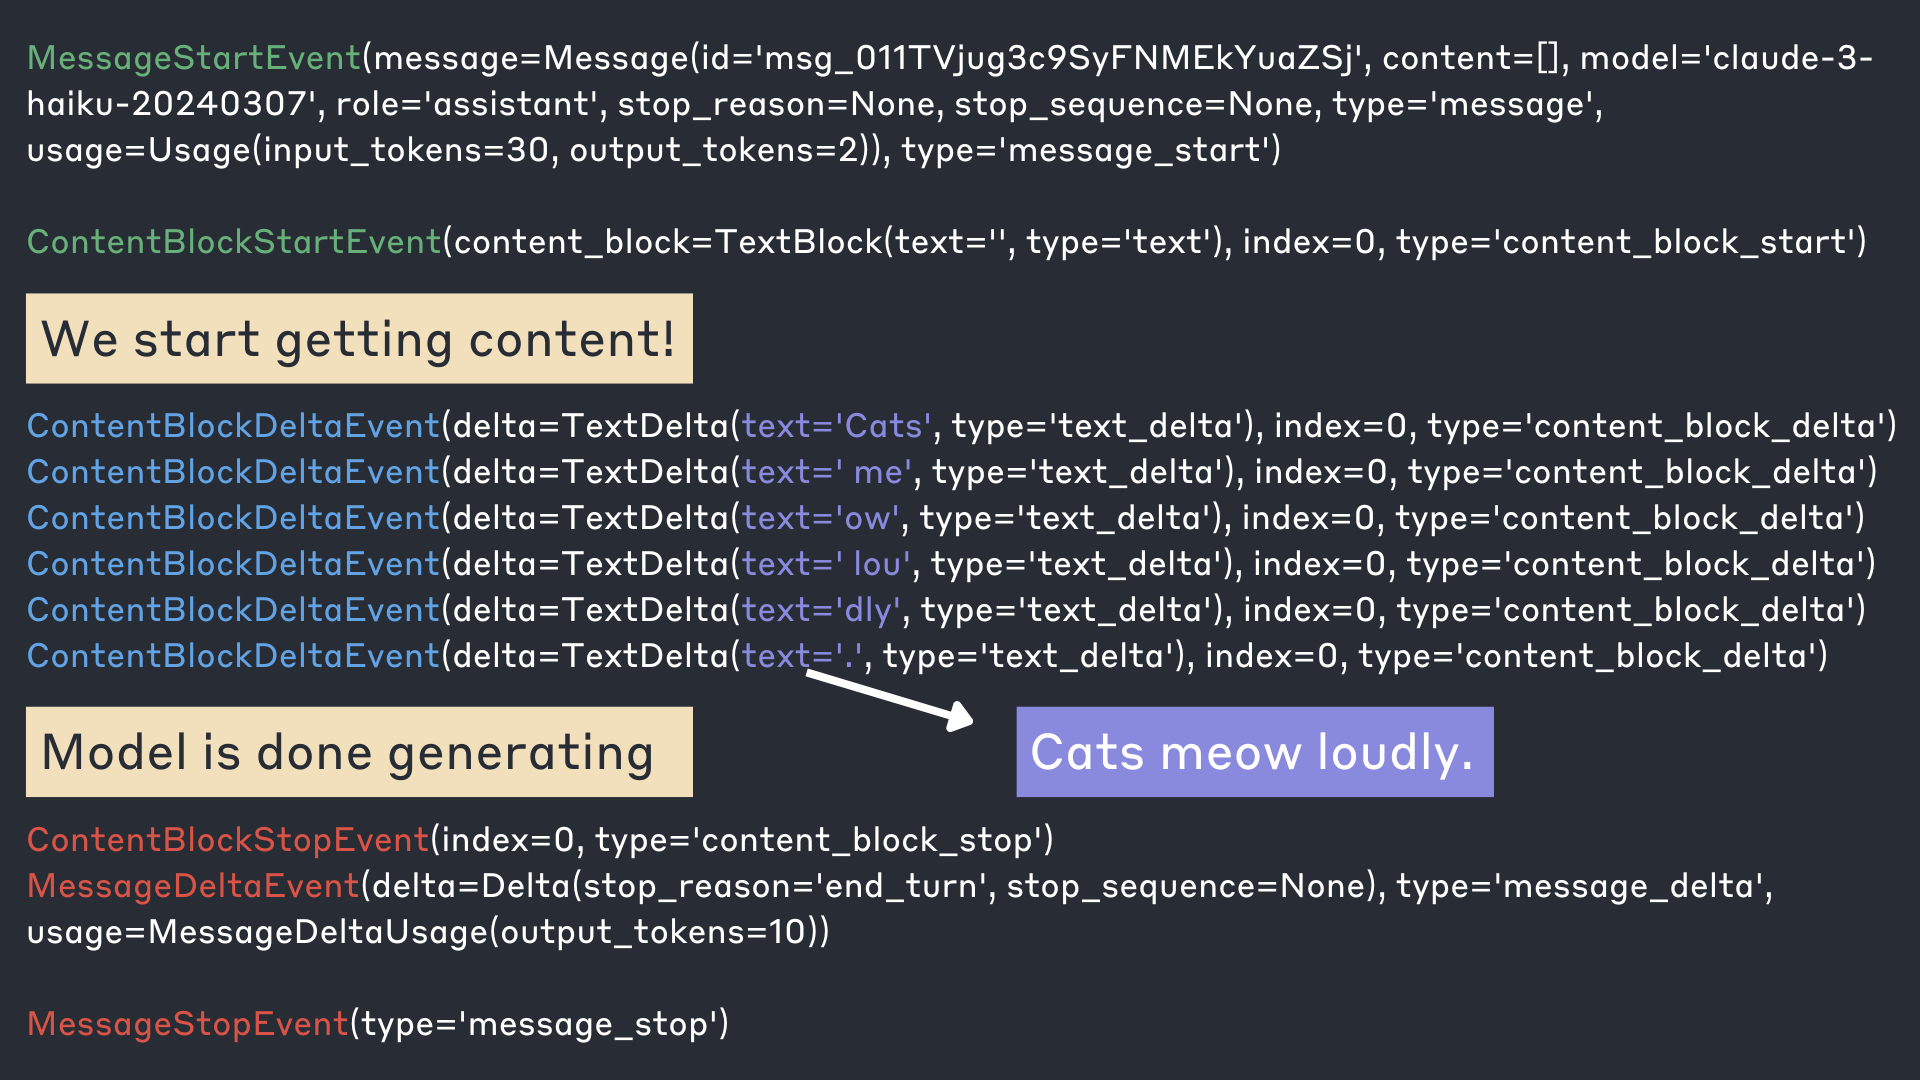

Each stream contains a series of events in the following order:
* **MessageStartEvent** - A message with empty content
* **Series of content blocks** - Each of which contains:
    * A **ContentBlockStartEvent**
    * One or more **ContentBlockDeltaEvent**s
    * A **ContentBlockStopEvent**
* One or more **MessageDeltaEvent**s which indicate top-level changes to the final message
* A final **MessageStopEvent**

In the above response, there was only a single content block.  This diagram shows all the events associated with it: 

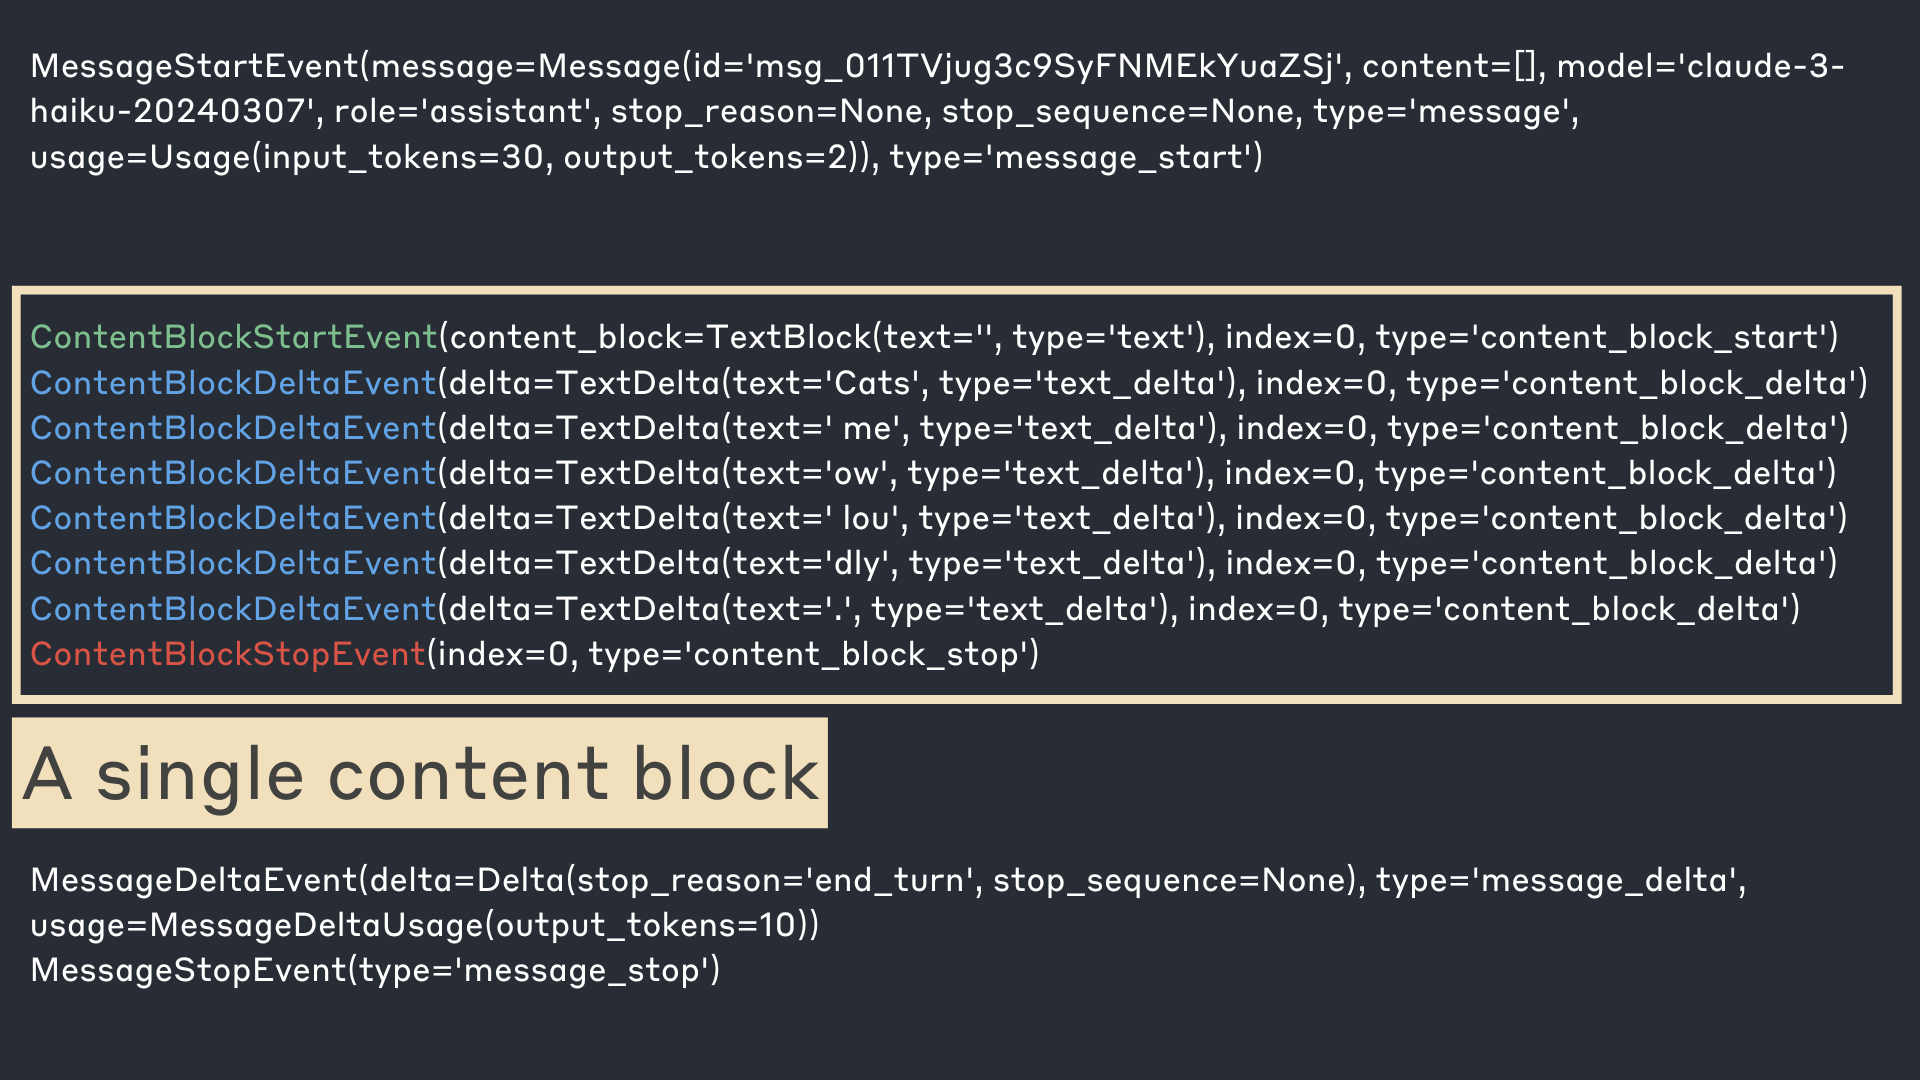

All of the actual model-generated content we care about comes from the ContentBlockDeltaEvents, which each contain a type set to "content_block_delta."  To actually get the content itself, we want to access the `text` property inside of `delta`.  Let's try exclusively printing out the text that was generated:

In [7]:
stream = client.messages.create(
    messages=[
        {
            "role": "user",
            "content": "Write me a 3 word sentence, without a preamble.  Just give me 3 words",
        }
    ],
    model="claude-3-haiku-20240307",
    max_tokens=100,
    temperature=0,
    stream=True,
)
for event in stream:
    if event.type == "content_block_delta":
        print(event.delta.text)

Cats
 me
ow lou
dly.


We are successfully printing out the content, though the way it's formatted is a little tricky to read.  When printing out the streamed text using Python's `print()` function, it's useful to pass two additional arguments:
* `end=""`: By default, the print() function adds a newline character (\n) at the end of the printed text. However, by setting end="", we specify that the printed text should not be followed by a newline character. This means that the next print() statement will continue printing on the same line.
* `flush=True`: The flush parameter is set to True to force the output to be immediately written to the console or standard output, without waiting for a newline character or the buffer to be filled. This ensures that the text is displayed in real-time as it is received from the streaming response.

Let's try making these changes: 

In [8]:
stream = client.messages.create(
    messages=[
        {
            "role": "user",
            "content": "Write me a 3 word sentence, without a preamble.  Just give me 3 words",
        }
    ],
    model="claude-3-haiku-20240307",
    max_tokens=100,
    temperature=0,
    stream=True,
)
for event in stream:
    if event.type == "content_block_delta":
        print(event.delta.text, flush=True, end="")

Cats meow loudly.

With such a short piece of text, the streaming functionality may not be obvious.  Let's try asking the model to generate something longer:

In [9]:
stream = client.messages.create(
    messages=[
        {
            "role": "user",
            "content": "How do large language models work?",
        }
    ],
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    temperature=0,
    stream=True,
)
for event in stream:
    if event.type == "content_block_delta":
        print(event.delta.text, flush=True, end="")

Large language models like myself work by using deep learning neural networks that are trained on massive amounts of text data. The key aspects are:

1. Neural network architecture - We use large, multi-layer neural networks with many parameters that can learn complex patterns in language.

2. Training data - We are trained on huge corpora of text from the internet, books, articles, and other sources. This allows us to learn the statistical patterns and structures of language.

3. Self-supervised learning - During training, the model learns to predict the next word in a sequence of text, without any explicit labels. This allows it to learn general language understanding.

4. Transfer learning - The knowledge gained during this pre-training can then be fine-tuned for specific tasks like question answering, summarization, translation, etc.

5. Attention mechanisms - Advanced models like transformers use attention to dynamically focus on the most relevant parts of the input when generatin

Try running the above cell if you haven't already.  You should see text content printed out incrementally as it comes in!

As we've seen, the ContentBlockDeltaEvents contain the text content generated by the model.  There are many other events, we need to care about those? Yes! Here's one quick example:

If we want to access information about our token usage, we'll need to look in two places:

* `MessageStartEvent` contains our input(prompt) token usage information
* `MessageDeltaEvent` contains information on how many output tokens were generated

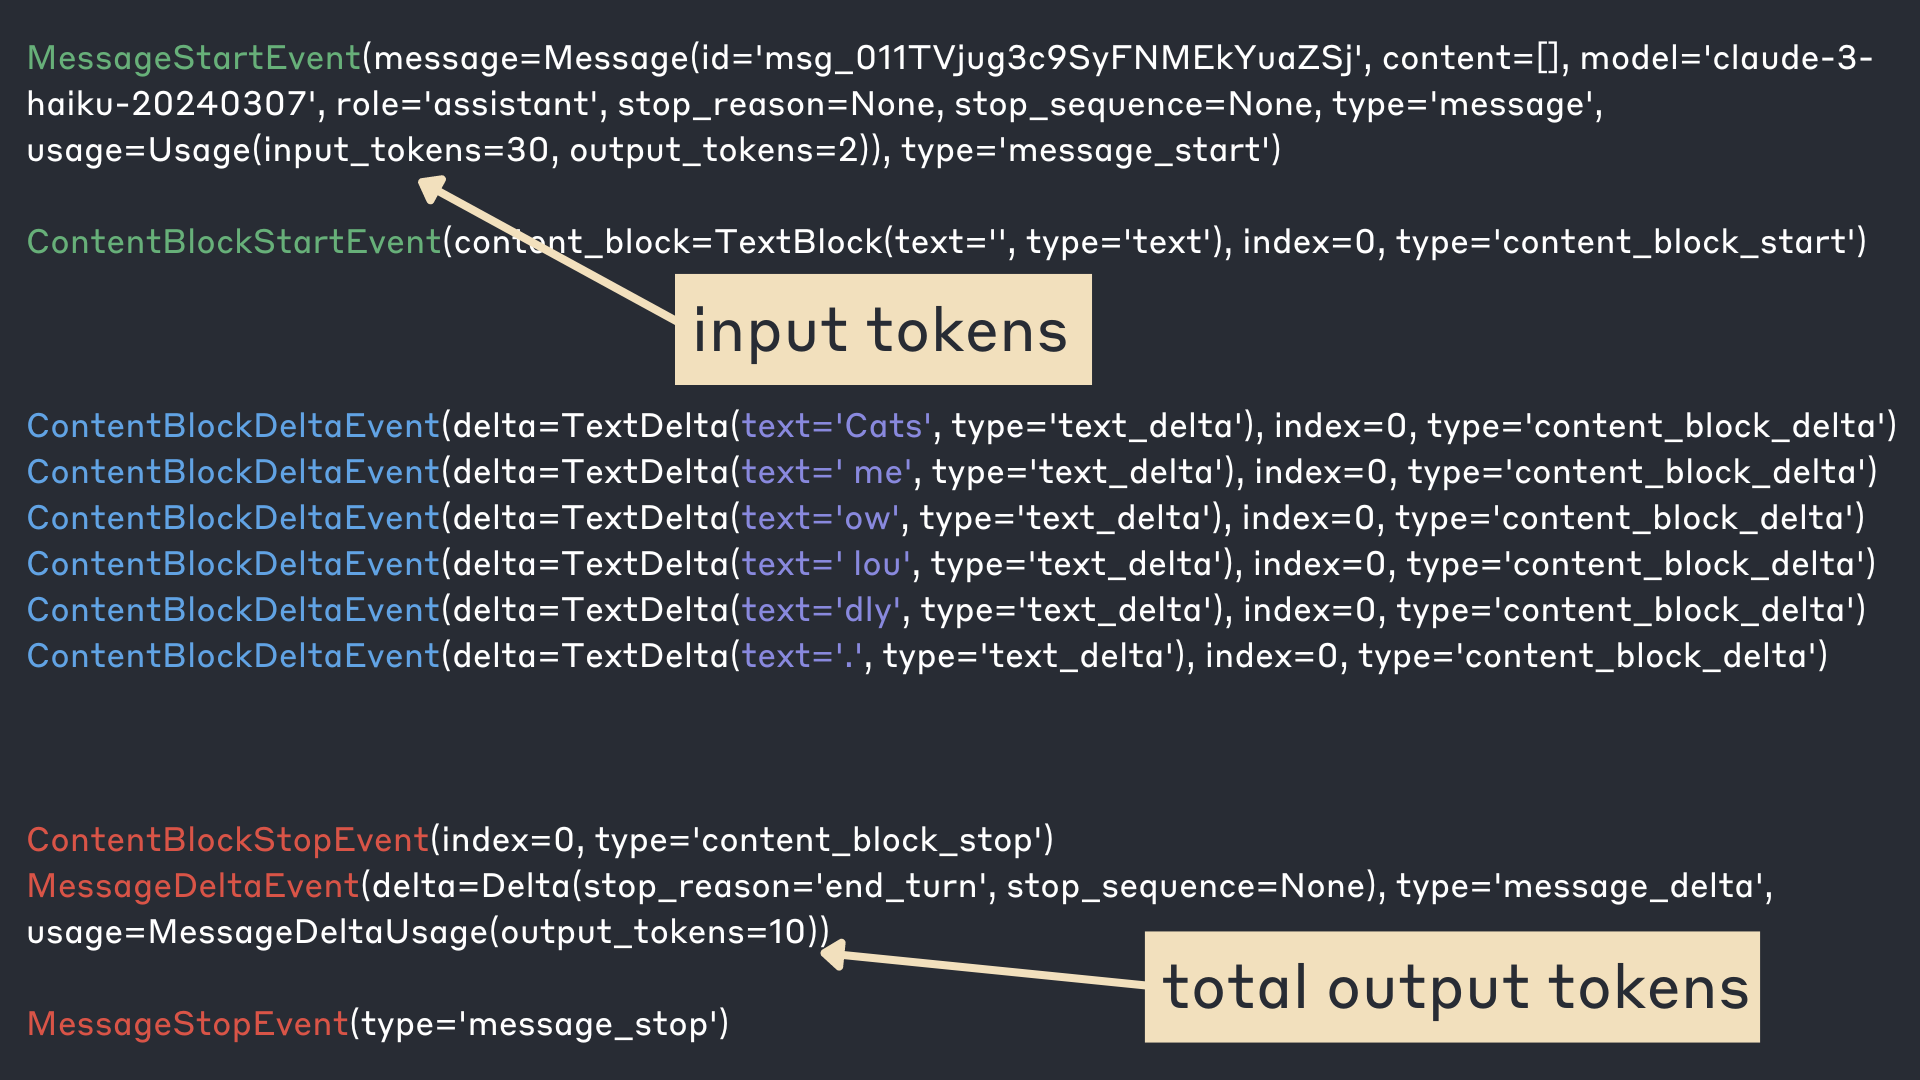

Let's update our code from above to print out how many tokens are used in our prompt and how many tokens the model generated:

In [42]:
stream = client.messages.create(
    messages=[
        {
            "role": "user",
            "content": "How do large language models work?",
        }
    ],
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    temperature=0,
    stream=True,
)
for event in stream:
    if event.type == "message_start":
        input_tokens = event.message.usage.input_tokens
        print("MESSAGE START EVENT", flush=True)
        print(f"Input tokens used: {input_tokens}", flush=True)
        print("========================")
    elif event.type == "content_block_delta":
        print(event.delta.text, flush=True, end="")
    elif event.type == "message_delta":
        output_tokens = event.usage.output_tokens
        print("\n========================", flush=True)
        print("MESSAGE DELTA EVENT", flush=True)
        print(f"Output tokens used: {output_tokens}", flush=True)
        

MESSAGE START EVENT
Input tokens used: 14
Large language models like myself work by using deep learning neural networks that are trained on massive amounts of text data. The key aspects are:

1. Neural network architecture - We use large, multi-layer neural networks with many parameters that can learn complex patterns in language.

2. Training data - We are trained on huge corpora of text from the internet, books, articles, and other sources. This allows us to learn the statistical patterns and structures of language.

3. Self-supervised learning - During training, the model learns to predict the next word in a sequence of text, without any explicit labels. This allows it to learn general language understanding.

4. Transfer learning - The knowledge gained during this pre-training can then be fine-tuned for specific tasks like question answering, summarization, translation, etc.

5. Attention mechanisms - Advanced models like transformers use attention to dynamically focus on the most 

### Other streaming event types

When working with streams, you may encounter some other event types including:

* **Ping events** - streams may also include any number of ping events.
* **Error events** - you may occasionally see error events in the event stream. For example, during periods of high usage, you may receive an overloaded_error, which would normally correspond to an HTTP 529 in a non-streaming context.

Here's an example error event: 

```
event: error
data: {"type": "error", "error": {"type": "overloaded_error", "message": "Overloaded"}}
```


## Time to first token (TTFT)

The major reason to use streaming is to improve your time to first token: that amount of time it takes for you or your user to receive the first bit of model generated content. 
Let's try and demonstrate the impact that streaming can have on TTFT.

We'll start with a non-streaming approach.  We'll ask the model to generate a very long piece of text but cut it off at 500 tokens:

In [4]:
import time
def measure_non_streaming_ttft():
    start_time = time.time()

    response = client.messages.create(
        max_tokens=500,
        messages=[
            {
                "role": "user",
                "content": "Write mme a long essay explaining the history of the American Revolution",
            }
        ],
        temperature=0,
        model="claude-3-haiku-20240307",
    )

    response_time = time.time() - start_time

    print(f"Time to receive first token: {response_time:.3f} seconds")
    print(f"Time to recieve complete response: {response_time:.3f} seconds")
    print(f"Total tokens generated: {response.usage.output_tokens}")
    
    print(response.content[0].text)

In [50]:
measure_non_streaming_ttft()

Time to receive first token: 4.194 seconds
Time to recieve complete response: 4.194 seconds
Total tokens generated: 500
Here is a long essay explaining the history of the American Revolution:

The American Revolution was a pivotal event in the history of the United States, marking the country's transition from a collection of British colonies to an independent nation. The roots of the revolution can be traced back to the French and Indian War, which was fought between Britain and France from 1754 to 1763. This conflict, which was part of a larger global war, resulted in the British gaining control of much of North America, including the French colonies. However, the war also left Britain with a significant debt, which it sought to recoup by imposing a series of taxes and regulations on its American colonies.

One of the first major events that led to the American Revolution was the Stamp Act, which was passed by the British Parliament in 1765. This act required all printed materials in

Now let's try the same thing using a streaming approach:

In [57]:
def measure_streaming_ttft():
    start_time = time.time()

    stream = client.messages.create(
        max_tokens=500,
        messages=[
            {
                "role": "user",
                "content": "Write mme a long essay explaining the history of the American Revolution",
            }
        ],
        temperature=0,
        model="claude-3-haiku-20240307",
        stream=True
    )
    have_received_first_token = False
    for event in stream:
        if event.type == "content_block_delta":
            if not have_received_first_token:
                ttft = time.time() - start_time
                have_received_first_token = True
            print(event.delta.text, flush=True, end="")
        elif event.type == "message_delta":
            output_tokens = event.usage.output_tokens
            total_time = time.time() - start_time

    print(f"\nTime to receive first token: {ttft:.3f} seconds", flush=True)
    print(f"Time to recieve complete response: {total_time:.3f} seconds", flush=True)
    print(f"Total tokens generated: {output_tokens}", flush=True)
    


In [58]:
measure_streaming_ttft()

Here is a long essay explaining the history of the American Revolution:

The American Revolution was a pivotal event in the history of the United States, marking the country's transition from a collection of British colonies to an independent nation. The roots of the revolution can be traced back to the French and Indian War, which was fought between Britain and France from 1754 to 1763. This conflict, which was part of a larger global war, resulted in the British gaining control of much of North America, including the French colonies. However, the war also left Britain with a significant debt, which it sought to recoup by imposing a series of taxes and regulations on its American colonies.

One of the first major events that led to the American Revolution was the Stamp Act, which was passed by the British Parliament in 1765. This act required all printed materials in the colonies, including newspapers, pamphlets, bills, legal documents, licenses, almanacs, dice, and playing cards, to 

Let's compare the results.

* **Without Streaming**
    * **Time to receive first token:** 4.194 seconds
    * **Time to recieve complete response:** 4.194 seconds
    * **Total tokens generated:** 500
* **With Streaming**
    * **Time to receive first token:** 0.492 seconds
    * **Time to recieve complete response:** 4.274 seconds
    * **Total tokens generated:** 500

As you can see, there's a huge difference in TTFT! This demo is only generating 500 tokens, and it's using Haiku which is our fastest model.  If we try an example that generates 1000 tokens using Opus, the numbers will be drastically different! 
    

In [2]:
def compare_ttft():
    def measure_streaming_ttft():
        start_time = time.time()

        stream = client.messages.create(
            max_tokens=1000,
            messages=[
                {
                    "role": "user",
                    "content": "Write mme a very very long essay explaining the history of the American Revolution",
                }
            ],
            temperature=0,
            model="claude-3-opus-20240229",
            stream=True
        )
        have_received_first_token = False
        for event in stream:
            if event.type == "content_block_delta":
                if not have_received_first_token:
                    ttft = time.time() - start_time
                    have_received_first_token = True
            elif event.type == "message_delta":
                output_tokens = event.usage.output_tokens
                total_time = time.time() - start_time
        return (ttft, output_tokens)
    
    def measure_non_streaming_ttft():
        start_time = time.time()

        response = client.messages.create(
            max_tokens=1000,
            messages=[
                {
                    "role": "user",
                    "content": "Write mme a very very long essay explaining the history of the American Revolution",
                }
            ],
            temperature=0,
            model="claude-3-opus-20240229"
        )
        ttft = time.time() - start_time
        return (ttft, response.usage.output_tokens)
    
    streaming_ttft, streaming_tokens = measure_streaming_ttft()
    non_streaming_ttft, non_streaming_tokens = measure_non_streaming_ttft()

    print("OPUS STREAMING")
    print(f"Time to first token: {streaming_ttft}")
    print(f"Tokens generated: {streaming_tokens}")
    print("#########################################################")
    print("OPUS NON STREAMING")
    print(f"Time to first token: {non_streaming_ttft}")
    print(f"Tokens generated: {non_streaming_tokens}")

        

In [5]:
# DO NOT RUN THIS! It takes over a minute to run and generates around 2000 tokens with Opus! 
compare_ttft()

OPUS STREAMING
Time to first token: 1.8863098621368408
Tokens generated: 997
#########################################################
OPUS NON STREAMING
Time to first token: 47.03177309036255
Tokens generated: 998


When we use Opus to generate a longer piece of text, the impact of streaming on TTFT is even more obvious. With a non-streaming approach, it took 47 seconds to get our first token.  With streaming, it only took 1.8 seconds to get our first token!  

**Note: Remember that streaming does not magically improve the overall time the moodel takes to generate a response.  We get initial data much faster, but it still takes the same amount of time between the start of our request and receiving the final generated token**



## Streaming helpers

The Python SDK provides several conveniences for streaming messages. Instead of using `client.messages.create` with `stream=True`, we can instead use `client.messages.stream` which gives us access to useful helper methods. `client.messages.stream()` returns a MessageStreamManager, which is a context manager that yields a MessageStream which is iterable, emits events, and accumulates messages. 

The code below uses `client.messages.stream` which allows us to use helpers like `stream.text_stream` to easily access generated text content as it streams in, without having to manually check the stream event type.  `stream.text_stream` provides an iterator over just the text deltas in the stream.

There are other useful helper methods like `get_final_message` which returns a final accumulated message once the stream has been read to completion.  This can be useful if you both want to use streaming but also need access to the entire finished text generation when it's complete.  You can of course write some code to build up your own accumulated message, but this helper method makes it easy.

The following example prints out each incoming piece of text as it is received, and also prints out the final completed message when the stream is complete:


In [79]:
from anthropic import AsyncAnthropic

client = AsyncAnthropic()

async def streaming_with_helpers():
    async with client.messages.stream(
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": "Write me sonnet about orchids",
            }
        ],
        model="claude-3-opus-20240229",
    ) as stream:
        async for text in stream.text_stream:
            print(text, end="", flush=True)

    final_message = await stream.get_final_message()
    print("\n\nSTREAMING IS DONE.  HERE IS THE FINAL ACCUMULATED MESSAGE: ")
    print(final_message.to_json())

await streaming_with_helpers()

In gardens fair, where beauty reigns supreme,
The orchid stands, a queen among the blooms,
Her delicate petals, like a lovely dream,
Adorned in nature's most exquisite plumes.

With colors ranging from pure white to bold,
And patterns intricate, a work of art,
Each blossom tells a story, bright and old,
Of evolution's path, a world apart.

From rainforests dense to mountain peaks so high,
The orchid thrives, a testament to grace,
Her beauty captivates the wandering eye,
And in our hearts, she finds a cherished place.

Oh, orchid fair, your splendor knows no bounds,
Forever in our gardens and hearts you'll be found.

STREAMING IS DONE.  HERE IS THE FINAL ACCUMULATED MESSAGE: 
{
  "id": "msg_018x1nZcs3sfq15zKaS4z4gD",
  "content": [
    {
      "text": "In gardens fair, where beauty reigns supreme,\nThe orchid stands, a queen among the blooms,\nHer delicate petals, like a lovely dream,\nAdorned in nature's most exquisite plumes.\n\nWith colors ranging from pure white to bold,\nAnd patter


When using `client.messages.stream()`, we can also define custom event handlers that run when any stream event occurs, or only when text is generated, etc.

The example below uses two of these custom event handlers. We use `client.messages.stream()` and ask the model to "generate a 5-word poem". We define our own `MyStream` class which has two event handlers defined:

* `on_text` - The event is fired when a text ContentBlock object is being accumulated. The first argument is the text delta and the second is the current accumulated text.  In the example below, we're using this event handler to print out any generated text as it streams in.  The text is printed out in green to make it easier to visualize.
* `on_stream_event` - The event is fired when any event is received from the API.  In the example below, we're printing the event type anytime an event is received.

We then pass an `event_handler` argument to `client.messages.stream` to register callback methods that are fired when certain events happen:


In [94]:
from anthropic import AsyncAnthropic, AsyncMessageStream

client = AsyncAnthropic()

green = '\033[32m'
reset = '\033[0m'

class MyStream(AsyncMessageStream):
    async def on_text(self, text, snapshot):
        # This runs only on text delta stream messages
        print(green + text + reset, flush=True) #model generated content is printed in green

    async def on_stream_event(self, event):
        # This runs on any stream event
        print("on_event fired:", event.type)

async def streaming_events_demo():
    async with client.messages.stream(
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": "Generate a 5-word poem",
            }
        ],
        model="claude-3-opus-20240229",
        event_handler=MyStream,
    ) as stream:
        # Get the final accumulated message, after the stream is exhausted
        message = await stream.get_final_message()
        print("accumulated final message: ", message.to_json())

await streaming_events_demo()

on_event fired: message_start
on_event fired: content_block_start
on_event fired: content_block_delta
Whis
on_event fired: content_block_delta
pers
on_event fired: content_block_delta
 dance
on_event fired: content_block_delta
,
on_event fired: content_block_delta
 secrets
on_event fired: content_block_delta
 unf
on_event fired: content_block_delta
ol
on_event fired: content_block_delta
d,
on_event fired: content_block_delta
 love
on_event fired: content_block_delta
.
on_event fired: content_block_stop
on_event fired: message_delta
on_event fired: message_stop
accumulated final message:  {
  "id": "msg_014G44rr3M14DzadHXPn9Xaj",
  "content": [
    {
      "text": "Whispers dance, secrets unfold, love.",
      "type": "text"
    }
  ],
  "model": "claude-3-opus-20240229",
  "role": "assistant",
  "stop_reason": "end_turn",
  "stop_sequence": null,
  "type": "message",
  "usage": {
    "input_tokens": 14,
    "output_tokens": 14
  }
}


The Python SDK gives us access to a handful of other event handlers we can utilize including: 

##### `on_message(message: Message)`
The event is fired when a full Message object has been accumulated. This corresponds to the message_stop SSE.

##### `on_content_block(content_block: ContentBlock)`
The event is fired when a full ContentBlock object has been accumulated. This corresponds to the content_block_stop SSE.

##### `on_exception(exception: Exception)`
The event is fired when an exception is encountered while streaming the response.

##### `on_timeout()`
The event is fired when the request times out.

##### `on_end()`
The last event fired in the stream.

***

## Exercise

Write a simple Claude chatbot that uses streaming. The following gif illustrates how it should work.  Please note that the color-coding of the output is completely optional and mostly helps to make the gif readable/watchable:

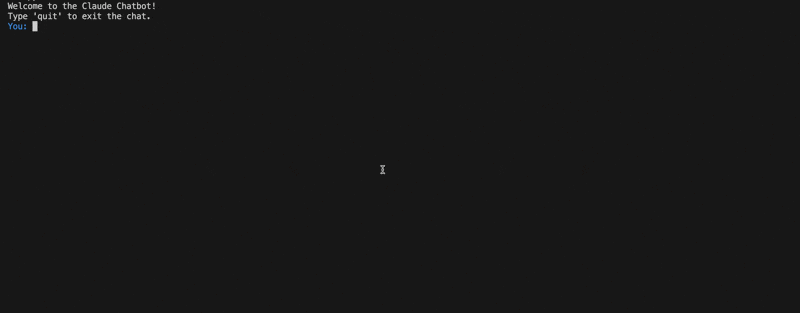

### Potential solution
The following solution is one simple implementation of the above exercise.  For the best experience, run it as a standalone Python script, not as a cell in this notebook:

In [ ]:
from anthropic import Anthropic

# Initialize the Anthropic client
client = Anthropic()

# ANSI color codes
BLUE = "\033[94m"
GREEN = "\033[92m"
RESET = "\033[0m"

def chat_with_claude():
    print("Welcome to the Claude Chatbot!")
    print("Type 'quit' to exit the chat.")
    
    conversation = []
    
    while True:
        user_input = input(f"{BLUE}You: {RESET}")
        
        if user_input.lower() == 'quit':
            print("Goodbye!")
            break
        
        conversation.append({"role": "user", "content": user_input})
        
        print(f"{GREEN}Claude: {RESET}", end="", flush=True)
        
        stream = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            messages=conversation,
            stream=True
        )
        
        assistant_response = ""
        for chunk in stream:
            if chunk.type == "content_block_delta":
                content = chunk.delta.text
                print(f"{GREEN}{content}{RESET}", end="", flush=True)
                assistant_response += content
        
        print()  # New line after the complete response
        
        conversation.append({"role": "assistant", "content": assistant_response})

if __name__ == "__main__":
    chat_with_claude()

***